# Purpose

The purpose of this notebook is to document the default choices chosen for this repository, recorded below:

- `coarse_grid=7` provides a fairly low run time while maintaining the best final error
- `fine_grid=100` provides a fairly low run time while maintaining the best final error
- `finish=fmin_powell` provides the best run time and lowest errors of the finish functions tested
- `method='L-BFGS-B` provdes the best run time nad lowest errors of the final optimization methods tested

# Code

## Imports

In [1]:
import os
import platform
import timeit
import numpy as np 
import pandas
from scipy import optimize
import dghf
from scripts import canvass_download
from scripts import prh_profile
import hill_test

## Record OS information

In [2]:
os.name, platform.uname(), platform.processor()

('posix',
 uname_result(system='Darwin', node='Patricks-MBP-3.attlocal.net', release='20.6.0', version='Darwin Kernel Version 20.6.0: Thu Jul  6 22:12:47 PDT 2023; root:xnu-7195.141.49.702.12~1/RELEASE_X86_64', machine='x86_64'),
 'i386')

# Plotting CANVASS examples

### Plot data exemplars

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 12.03it/s]


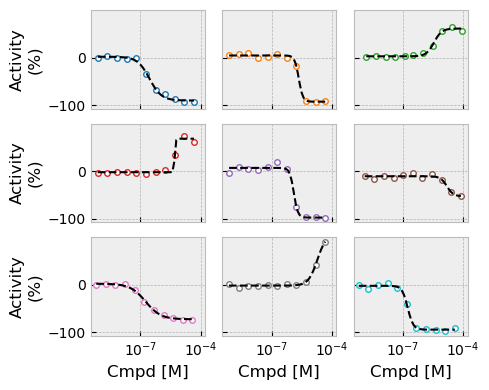

In [3]:
x_y = canvass_download.demo_x_y_data()
all_fit_kw = [dghf.fit(x,y) for x,y in x_y]
fig = dghf.gallery_plot(x_y=x_y,all_fit_kw=all_fit_kw)

### Plot random subset of data

In [4]:
n_sample = 25
df_canvass = canvass_download.\
    read_canvass_data(out_dir="./out/test/cache_canvass",
                      random_sample=n_sample,random_seed=55)
x_y_dict = {id_v:(df_v["Concentration (M)"].to_numpy(),df_v["Activity (%)"].to_numpy())
            for id_v , df_v in df_canvass.groupby("Curve ID")}
ids = sorted(set(x_y_dict.keys()))
x_y = [ x_y_dict[i] for i in ids]
all_fit_kw = [dghf.fit(x,y,inactive_range=[-50,50],coarse_n=11) for x,y in x_y]
# plot some ids on the titles
ids_plot = [ "\n".join(str(int(float(e)))
                       for e in i.split("___")[-2::])
            for i in ids]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.29it/s]


/var/folders/w1/v5ff3b610tlc7r14nb62lfsr0000gn/T/ipykernel_54226/1621784664.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


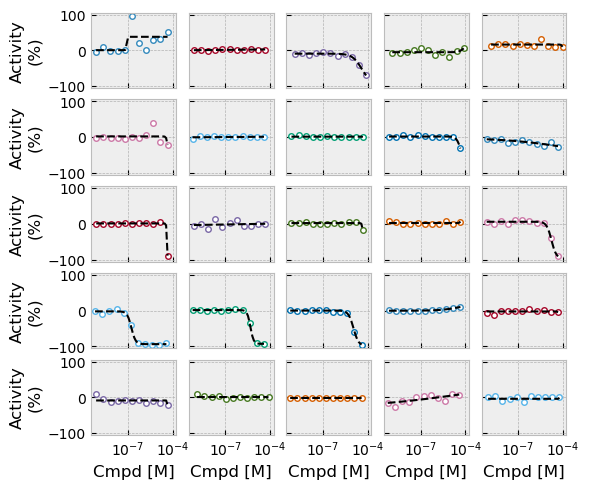

In [6]:
# could add ids_plot=ids_plot to show titles
fig = dghf.gallery_plot(x_y=x_y,all_fit_kw=all_fit_kw,figsize=(6,5))
fig.savefig("./out/canvass_examples_random.svg")
fig.show()

## Optimizing fit parameters

## Get simulated data

In [7]:
simulated_data = hill_test.simulated_data()
# ignore the all nan data set
x_y_kw = [s[0] for s in simulated_data if not set(s[0][-1].values()) == set([np.nan])]
# all of the simulated data has positive hill coefficient
bounds_n = [0,np.inf]

### Determining optimum coarse grid size

In [8]:
prh_profile.\
    plot_error_and_time(kw_fit_arr=[dict(coarse_n=coarse_n) for coarse_n in [1,2,3,4,5,6,7,8,9,10]],
                        x_y_kw=x_y_kw,title = "Error versus brute grid points",
                        bounds_n=bounds_n,x="coarse_n")

### Determining optimum fine grid size

In [9]:
prh_profile.\
    plot_error_and_time(kw_fit_arr=[dict(fine_n=fine_n) for fine_n in [2,5,10,20,50,100,200,500,1000]],
                        x_y_kw=x_y_kw,title = "Error versus brute fine grid points",
                        bounds_n=bounds_n,x="fine_n",log_x=True)

### Determining optimum brute finish

In [10]:
prh_profile.\
    plot_error_and_time(kw_fit_arr=[dict(finish=fin) for fin in [optimize.fmin,optimize.fmin_powell,
                                                                 optimize.fmin_cg,optimize.fmin_bfgs]],
                        x_y_kw=x_y_kw,title = "Error versus brute finish",width=500,
                        bounds_n=bounds_n,x="finish",convert_v={"finish":lambda x: str(x).split(" at ")[0].replace("<function ","")})

### Determining optimum final polish

In [11]:
# note: 'dogleg','trust-ncg', 'trust-krylov','trust-exact' need hessian.  'COBYQA' and  'trust-constr' are very long
all_methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 
               'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
prh_profile.\
    plot_error_and_time(kw_fit_arr=[dict(method=method) for method in all_methods],time_repeats=30,
                        x_y_kw=x_y_kw,title = "Error versus brute grid points",width=900,
                        bounds_n=bounds_n,x="method")